# Problem Domain

The idea of this project is to simulate FIFA 2022 World Cup games using machine learning in order to predict the competition's winner.

This notebook uses two datasets [international-football-results-from-1872-to-2017](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) and [fifaworldranking](https://www.kaggle.com/datasets/cashncarry/fifaworldranking)

## Data Preparation

Preparing the data to apply for feature engineering methods that will create the training data for machine learning.

Downloading the FIFA World Ranking by rank_date

In [11]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/cashncarry/fifaworldranking?select=fifa_ranking-2022-12-22.csv", data_dir='/tmp/', force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: endritberisha
Your Kaggle Key: ········


100%|█████████████████████████████████████████████████████████████████████████████████████| 532k/532k [00:00<00:00, 3.29MB/s]

In [12]:
#https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml

In [105]:
from difflib import SequenceMatcher
from tqdm import tqdm
from operator import itemgetter
from collections.abc import Iterable

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

AFTER_2018 = '2018-08-01'

In [14]:
def read_results(url):
    df = pd.read_csv(url)
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'] > AFTER_2018]
    df.reset_index(drop=True, inplace=True)
    return df
    
results = read_results('https://raw.githubusercontent.com/martj42/international_results/master/results.csv')

In [15]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,2018-08-04,Belize,Barbados,1,0,Friendly,San Pedro,Belize,False
1,2018-08-04,Palestine,Iraq,0,3,Friendly,Al-Ram,Palestine,False
2,2018-08-15,Guatemala,Cuba,3,0,Friendly,Guatemala City,Guatemala,False
3,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True
4,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False


In [16]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3945 entries, 0 to 3944
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        3945 non-null   datetime64[ns]
 1   home_team   3945 non-null   object        
 2   away_team   3945 non-null   object        
 3   home_score  3945 non-null   int64         
 4   away_score  3945 non-null   int64         
 5   tournament  3945 non-null   object        
 6   city        3945 non-null   object        
 7   country     3945 non-null   object        
 8   neutral     3945 non-null   bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(5)
memory usage: 250.5+ KB


In [17]:
results.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

We can see that the dataframe does not have any null values!

In [18]:
results.dtypes

date          datetime64[ns]
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
dtype: object

###### Read the ranking dataset from 1992 to 2022 and take AFTER 2018

In [19]:
rankings = pd.read_csv('/tmp/fifaworldranking/fifa_ranking-2022-12-22.csv')
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])
rankings = rankings[rankings['rank_date'] > AFTER_2018].reset_index(drop=True)

In [20]:
rankings.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,France,FRA,1726.0,1576.0,-6,UEFA,2018-08-16
1,202,Cayman Islands,CAY,880.0,880.0,0,CONCACAF,2018-08-16
2,67,Guinea,GUI,1344.0,1344.0,-1,CAF,2018-08-16
3,67,Côte d'Ivoire,CIV,1344.0,1344.0,-1,CAF,2018-08-16
4,66,Algeria,ALG,1351.0,1352.0,0,CAF,2018-08-16


In [21]:
rankings.isna().sum()

rank               0
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [22]:
rankings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7364 entries, 0 to 7363
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   rank             7364 non-null   int64         
 1   country_full     7364 non-null   object        
 2   country_abrv     7364 non-null   object        
 3   total_points     7364 non-null   float64       
 4   previous_points  7364 non-null   float64       
 5   rank_change      7364 non-null   int64         
 6   confederation    7364 non-null   object        
 7   rank_date        7364 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 460.4+ KB


In [23]:
# lots of friendly games
results.tournament.value_counts()

Friendly                                      1093
FIFA World Cup qualification                   866
UEFA Nations League                            468
UEFA Euro qualification                        262
African Cup of Nations qualification           215
CONCACAF Nations League                        173
African Cup of Nations                         104
CONCACAF Nations League qualification           68
African Nations Championship qualification      64
FIFA World Cup                                  64
Gold Cup                                        62
Copa América                                    54
AFC Asian Cup                                   51
UEFA Euro                                       51
COSAFA Cup                                      44
AFC Asian Cup qualification                     40
Arab Cup                                        32
AFF Championship                                26
SAFF Cup                                        23
Pacific Games                  

*Check if country names in results dataframe match with country names in rankings database. Adjust those that doesn't match either way.*

In [24]:
def similar(a, b):
    return np.round(SequenceMatcher(None, a, b).ratio(), 2)

def check_country_name_matchings(results, rankings):
    
    similar_country_names = {"country_A": [], 'country_B': []}
    
    results_countries = list(results.away_team.unique())
    rankings_countries = list(rankings.country_full.unique())
    diff_A = sorted(list(set(results_countries).difference(rankings_countries)))
    diff_B = sorted(list(set(rankings_countries).difference(results_countries)))

    for country_A in diff_A:
        for country_B in diff_B:
            if country_A == country_B:
                continue
            similarity = similar(country_A, country_B)
            if similarity >= 0.78:
                print(f'Country {country_A} to {country_B} is similar with a probability of', similarity)
                similar_country_names['country_A'].append(country_A)
                similar_country_names['country_B'].append(country_B)
                
    return similar_country_names
                
    
similar_country_names = check_country_name_matchings(results, rankings)

Country Cape Verde to Cabo Verde is similar with a probability of 0.8
Country Saint Kitts and Nevis to St Kitts and Nevis is similar with a probability of 0.92
Country Saint Kitts and Nevis to St. Kitts and Nevis is similar with a probability of 0.9
Country Saint Lucia to St Lucia is similar with a probability of 0.84
Country Saint Lucia to St. Lucia is similar with a probability of 0.8
Country Saint Vincent and the Grenadines to St Vincent and the Grenadines is similar with a probability of 0.95
Country Saint Vincent and the Grenadines to St. Vincent / Grenadines is similar with a probability of 0.79
Country Saint Vincent and the Grenadines to St. Vincent and the Grenadines is similar with a probability of 0.94


Replace country names on rankings based on the dictionary

In [25]:
for c_A, c_B in zip(similar_country_names['country_A'], similar_country_names['country_B']):
    rankings.country_full.str.replace(c_A, c_B)
    
#manually replace some countries that didnt make the cut
rankings['country'] = rankings.country_full.str.replace('USA', 'United States').str.replace('Korea Republic', 'South Korea').str.replace('IR Iran', 'Iran')

In [26]:
rankings = rankings.set_index(['rank_date']).groupby(['country'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [27]:
rankings = rankings[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]]

In [28]:
rankings.head()

,country_full,total_points,previous_points,rank,rank_change,rank_date
0,Afghanistan,1068.0,1068.0,145.0,0.0,2018-08-16
1,Afghanistan,1068.0,1068.0,145.0,0.0,2018-08-17
2,Afghanistan,1068.0,1068.0,145.0,0.0,2018-08-18
3,Afghanistan,1068.0,1068.0,145.0,0.0,2018-08-19
4,Afghanistan,1068.0,1068.0,145.0,0.0,2018-08-20


##### Merge international games and rankings both on home team and away team

In [29]:
df = results.merge(rankings, left_on=['date', 'home_team'], right_on=['rank_date', 'country_full']).drop(['rank_date', 'country_full'], axis=1)
df = df.merge(rankings, left_on=['date', 'away_team'], right_on=['rank_date', 'country_full'], suffixes=("_home", "_away")).drop(['rank_date', 'country_full'], axis=1)

In [30]:
df.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True,1120.0,1120.0,130.0,0.0,1312.0,1312.0,77.0,0.0
1,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False,980.0,980.0,168.0,0.0,1400.0,1400.0,54.0,0.0


In [31]:
df[df['home_team']=='Kosovo'].tail(4)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
2974,2022-06-09,Kosovo,Northern Ireland,3,2,UEFA Nations League,Pristina,Kosovo,False,1173.90,1163.05,107.0,-2.0,1423.55,1424.97,54.0,0.0
3192,2022-09-27,Kosovo,Cyprus,5,1,UEFA Nations League,Pristina,Kosovo,False,1183.90,1183.90,106.0,0.0,1180.52,1180.52,108.0,1.0
3217,2022-11-16,Kosovo,Armenia,2,2,Friendly,Pristina,Kosovo,False,1187.01,1183.90,107.0,1.0,1233.93,1242.42,93.0,1.0
3257,2022-11-19,Kosovo,Faroe Islands,1,1,Friendly,Pristina,Kosovo,False,1187.01,1183.90,107.0,1.0,1147.17,1136.29,122.0,-3.0


In [32]:
len(df)

3339

Data is ready

## Feature Engineering

Create possible features that have impact on predicting football games.

Idea is to create feature that have impact on prediction football games. Some features that might have impact are:

* Past games points made
* Past games goals scored and taken
* The importance of game (Friendly or not)
* Rank of the teams
* Rank increasmenet of the teams
* Goals made and taken by ranking

First thing to do is assign points of the game and the result

In [33]:
def result(home_score, away_score):
    if home_score > away_score:
        return pd.Series([0, 3, 0])
    elif home_score < away_score:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])
    
results = df.apply(lambda x: result(x['home_score'], x['away_score']), axis=1)

In [34]:
df[["result", "home_team_points", "away_team_points"]] = results

Game points are 3 for win, 1 for draw and 0 for lose

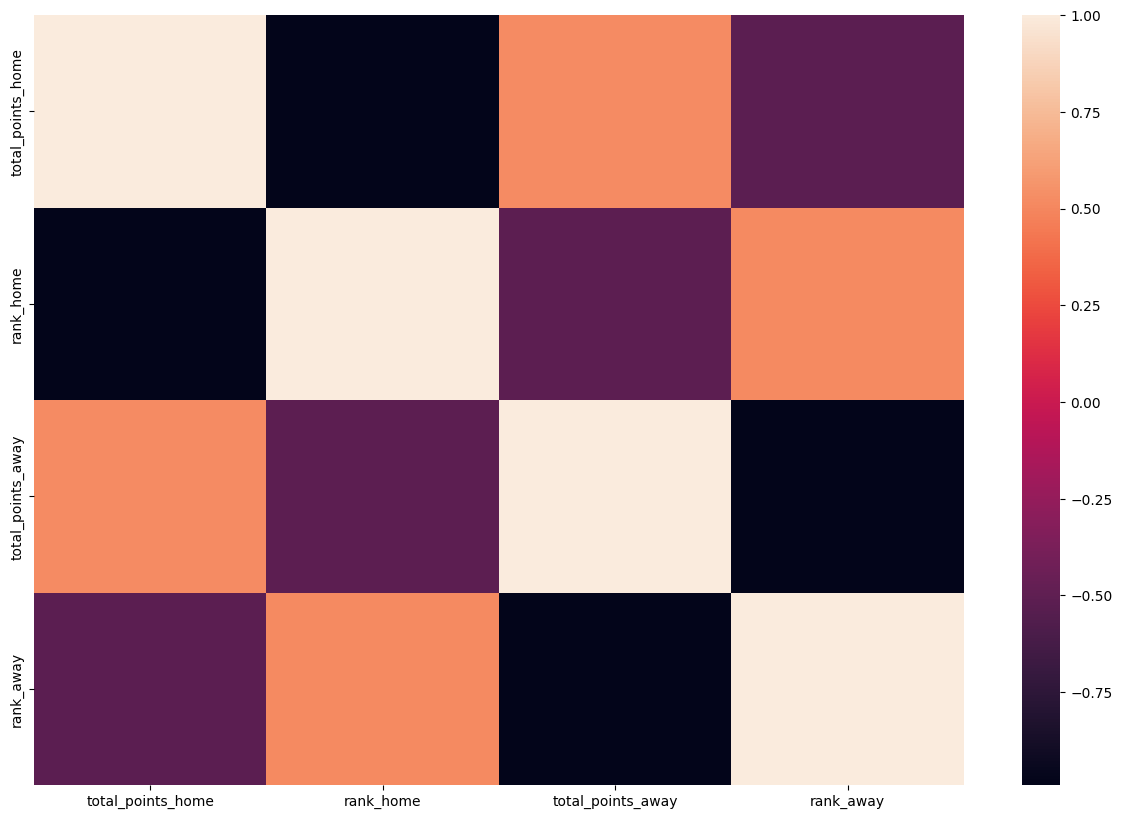

In [35]:
plt.figure(figsize=(15, 10))
sns.heatmap(df[['total_points_home', 'rank_home', 'total_points_away', 'rank_away']].corr())
plt.show()

Creating columns that will help in creation of the features: ranking difference, points won at the game vs/ team faced_rank, goals difference in the game

In [36]:
df['rank_diff'] = df['rank_home'] - df['rank_away']
df['score_diff'] = df['home_score'] - df['away_score']
df['points_home_by_rank'] = df['home_team_points']/df['rank_away']
df['points_away_by_rank'] = df['away_team_points']/df['rank_home']

In [37]:
df.tail(1)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_diff,score_diff,points_home_by_rank,points_away_by_rank
3338,2022-12-18,Argentina,France,3,3,FIFA World Cup,Lusail,Qatar,True,1773.88,1770.65,3.0,0.0,1759.78,1764.85,4.0,0.0,2,1,1,-1.0,0,0.25,0.333333


In order to create the features, separating the dataset in home team's and away team's dataset, unify them and calculate the past game values.
This proccess optimizes the creation of the features.

In [38]:
home_team = df[["date", "home_team", "home_score", "away_score", "tournament", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_diff", "points_home_by_rank", "home_team_points"]]
away_team = df[["date", "away_team", "away_score", "home_score", "tournament", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_diff", "points_away_by_rank", "away_team_points"]]

In [39]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]
away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [40]:
team_stats_raw = pd.concat([home_team, away_team]).copy()
team_stats_raw

,date,team,score,suf_score,tournament,rank,rank_suf,rank_change,total_points,result,rank_diff,points_by_rank,team_points
0,2018-08-18,Andorra,0,0,Friendly,130.0,77.0,0.0,1120.00,2,53.0,0.012987,1
1,2018-08-18,Grenada,1,5,Friendly,168.0,54.0,0.0,980.00,1,114.0,0.000000,0
2,2018-08-18,Guatemala,1,0,Friendly,146.0,181.0,0.0,1064.00,0,-35.0,0.016575,3
3,2018-08-20,Barbados,2,2,Friendly,160.0,54.0,0.0,1005.00,2,106.0,0.018519,1
4,2018-08-26,Barbados,0,0,Friendly,160.0,181.0,0.0,1005.00,2,-21.0,0.005525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,2022-12-14,Maldives,0,3,Friendly,154.0,146.0,-2.0,1026.09,0,-8.0,0.000000,0
3335,2022-12-14,Philippines,0,1,Friendly,133.0,96.0,-1.0,1115.13,0,-37.0,0.000000,0
3336,2022-12-17,Morocco,1,2,FIFA World Cup,22.0,12.0,-1.0,1563.50,0,-10.0,0.000000,0
3337,2022-12-17,Maldives,1,3,Friendly,154.0,160.0,-2.0,1026.09,0,6.0,0.000000,0


Now we have the data to create predictive feature

In [41]:
stats = []

for index, row in tqdm(team_stats_raw.iterrows()):
    team = row['team']
    date = row['date']
    past_games = team_stats_raw.loc[(team_stats_raw['team'] == team) & (team_stats_raw['date'] < date)].sort_values(by=['date'], ascending=False)
    last_5 = past_games.head(5)
    
    goals = past_games['score'].mean()
    goals_last_5 = last_5['score'].mean()
    
    goals_suf = past_games['suf_score'].mean()
    goals_suf_last_5 = last_5['suf_score'].mean()
    
    rank = past_games['rank_suf'].mean()
    rank_last_5 = last_5['rank_suf'].mean()
    
    if len(last_5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]
        points_last_5 = last_5["total_points"].values[0] - last_5["total_points"].values[-1] 
    else:
        points = 0
        points_last_5 = 0
        
        
    team_points = past_games['team_points'].mean()
    team_points_last_5 = last_5['team_points'].mean()
    
    points_by_rank = past_games['points_by_rank'].mean()
    points_by_rank_last_5 = last_5['points_by_rank'].mean()
    
    stats.append([goals, goals_last_5, goals_suf, goals_suf_last_5, rank, rank_last_5, points, points_last_5, team_points, team_points_last_5, points_by_rank, points_by_rank_last_5])    

6678it [00:05, 1314.56it/s]


In [42]:
stats_cols = ["goals_mean", "goals_mean_last_5", "goals_suf_mean",
              "goals_suf_mean_last_5", "rank_mean", "rank_mean_last_5",
              "points_mean", "points_mean_last_5", "team_points_mean",
              "team_points_mean_last_5", "points_rank_mean",
              "points_rank_mean_last_5"]
stats_df = pd.DataFrame(stats, columns=stats_cols)
full_df = pd.concat([team_stats_raw.reset_index(drop=True), stats_df], axis=1, ignore_index=True)
full_df.columns = list(team_stats_raw.columns) + stats_cols

In [43]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [44]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [45]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [46]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [47]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

Now, to quantify game importance, is created a column that finds competition of the game.

In [48]:
full_df['is_friendly'] = full_df['tournament'].apply(lambda x: 1 if x=='Friendly' else 0)

In [49]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [50]:
full_df.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away,result,home_team_points,away_team_points,rank_diff,score_diff,points_home_by_rank,points_away_by_rank,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1
0,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True,1120.0,1120.0,130.0,0.0,1312.0,1312.0,77.0,0.0,2,1,1,53.0,0,0.012987,0.007692,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,1
1,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False,980.0,980.0,168.0,0.0,1400.0,1400.0,54.0,0.0,1,0,3,114.0,-4,0.000000,0.017857,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,1


And, after that, we select only columns that will help in Features' analysis.

In [51]:
base_df = full_df.drop(['tournament', 'city', 'country', 'neutral', 'total_points_home', 'previous_points_home', 'total_points_away', 'previous_points_away', 'home_team_points', 'away_team_points', 'score_diff', 'points_home_by_rank', 'points_away_by_rank'], axis=1)

In [52]:
base_df.tail(2)

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1
3337,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.344828,1.4,1.620690,1.6,125.172414,122.6,28.75,-7.52,1.379310,1.0,0.009629,0.00724,1.111111,1.4,1.740741,1.6,149.407407,161.4,-21.91,0.59,1.259259,1.8,0.007310,0.009363,0,1
3338,2022-12-18,Argentina,France,3,3,3.0,0.0,4.0,0.0,2,-1.0,1.964286,2.2,0.571429,0.6,36.267857,19.4,199.88,0.00,2.232143,2.6,0.136649,0.16002,2.074074,1.8,0.814815,0.8,40.925926,18.6,33.78,0.00,2.166667,2.4,0.175278,0.230350,1,0


In [53]:
base_df.isna().sum()

date                              0
home_team                         0
away_team                         0
home_score                        0
away_score                        0
rank_home                         0
rank_change_home                  0
rank_away                         0
rank_change_away                  0
result                            0
rank_diff                         0
home_goals_mean                 100
home_goals_mean_last_5          100
home_goals_suf_mean             100
home_goals_suf_mean_last_5      100
home_rank_mean                  100
home_rank_mean_last_5           100
home_points_mean                  0
home_points_mean_last_5           0
home_team_points_mean           100
home_team_points_mean_last_5    100
home_points_rank_mean           100
home_points_rank_mean_last_5    100
away_goals_mean                  98
away_goals_mean_last_5           98
away_goals_suf_mean              98
away_goals_suf_mean_last_5       98
away_rank_mean              

## Data Analysis

Analyze all features that were created and check if they have predictive power.

If they don't, we need to create some that have, like differences of home and away teams.

In [54]:
df = base_df.dropna()

In [55]:
df['target'] = df['result'].apply(lambda x: 1 if x==2 else x)

/var/folders/tr/qq7qwqx91mq6jv07l_3ksqlm0000gn/T/ipykernel_52000/1606294925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['result'].apply(lambda x: 1 if x==2 else x)


Analysis that will be made:

Violin and boxplot to analyze if the features have different distributions according to the target
Scatter plots to analyze correlations

In [56]:
data1 = df[['rank_diff', 'rank_change_home', 'rank_change_away'] + list(df.columns[11:19].values) + ['target']]
data2 = df[df.columns[19:]]

In [57]:
scaled = (data1[:-1] -data1[:-1].mean()) / data1[:-1].std()
scaled['target'] = data1['target']
violin1 = pd.melt(scaled, id_vars='target', var_name='features', value_name='value')

scaled = (data2[:-1] -data2[:-1].mean()) / data2[:-1].std()
scaled['target'] = data2['target']
violin2 = pd.melt(scaled, id_vars='target', var_name='features', value_name='value')

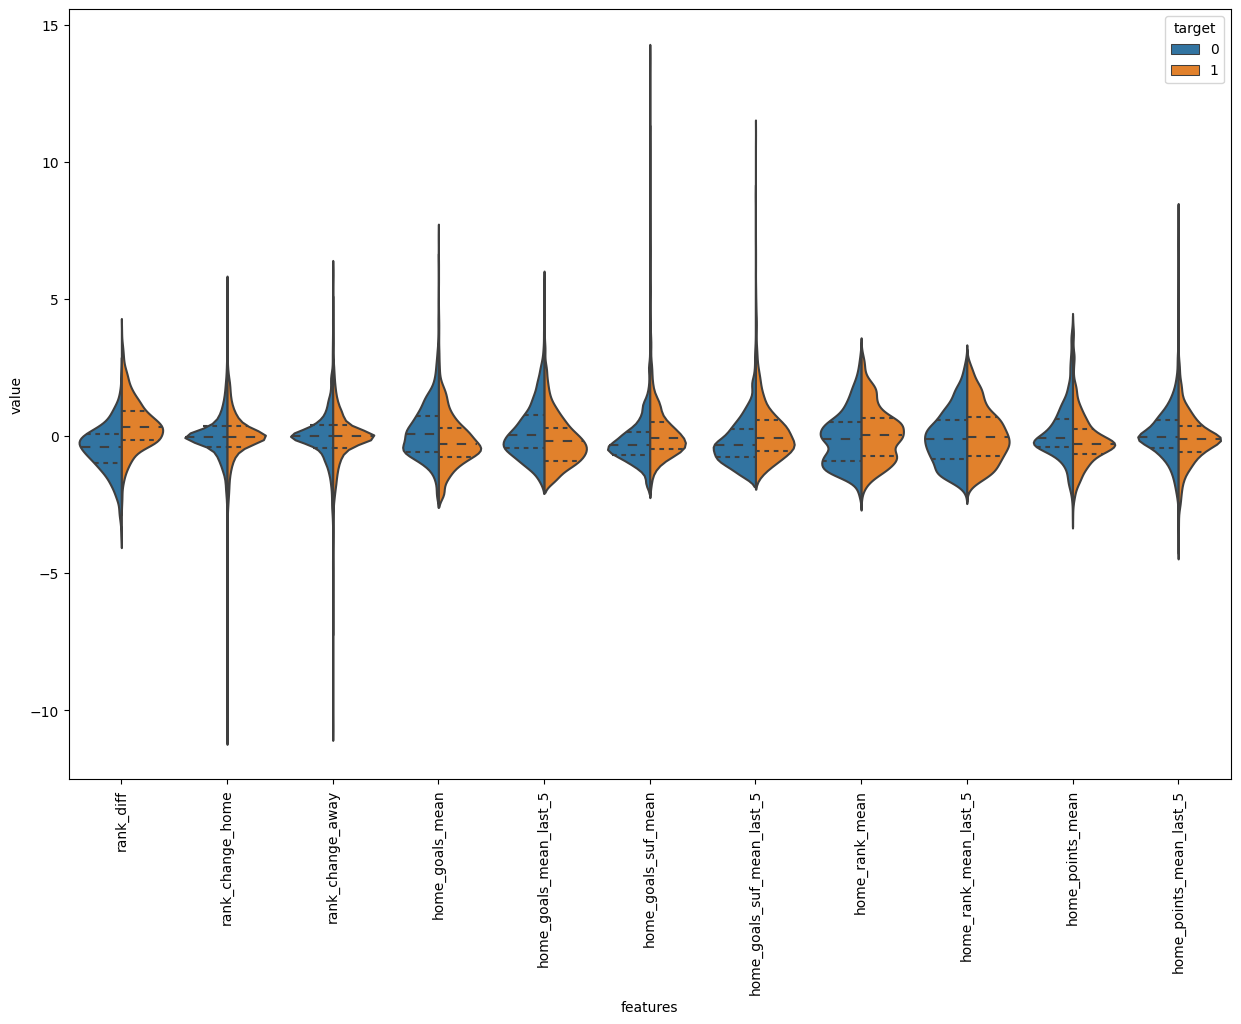

In [58]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='features', y='value', hue='target', data=violin1, split=True, inner='quart')
plt.xticks(rotation=90)
plt.show()

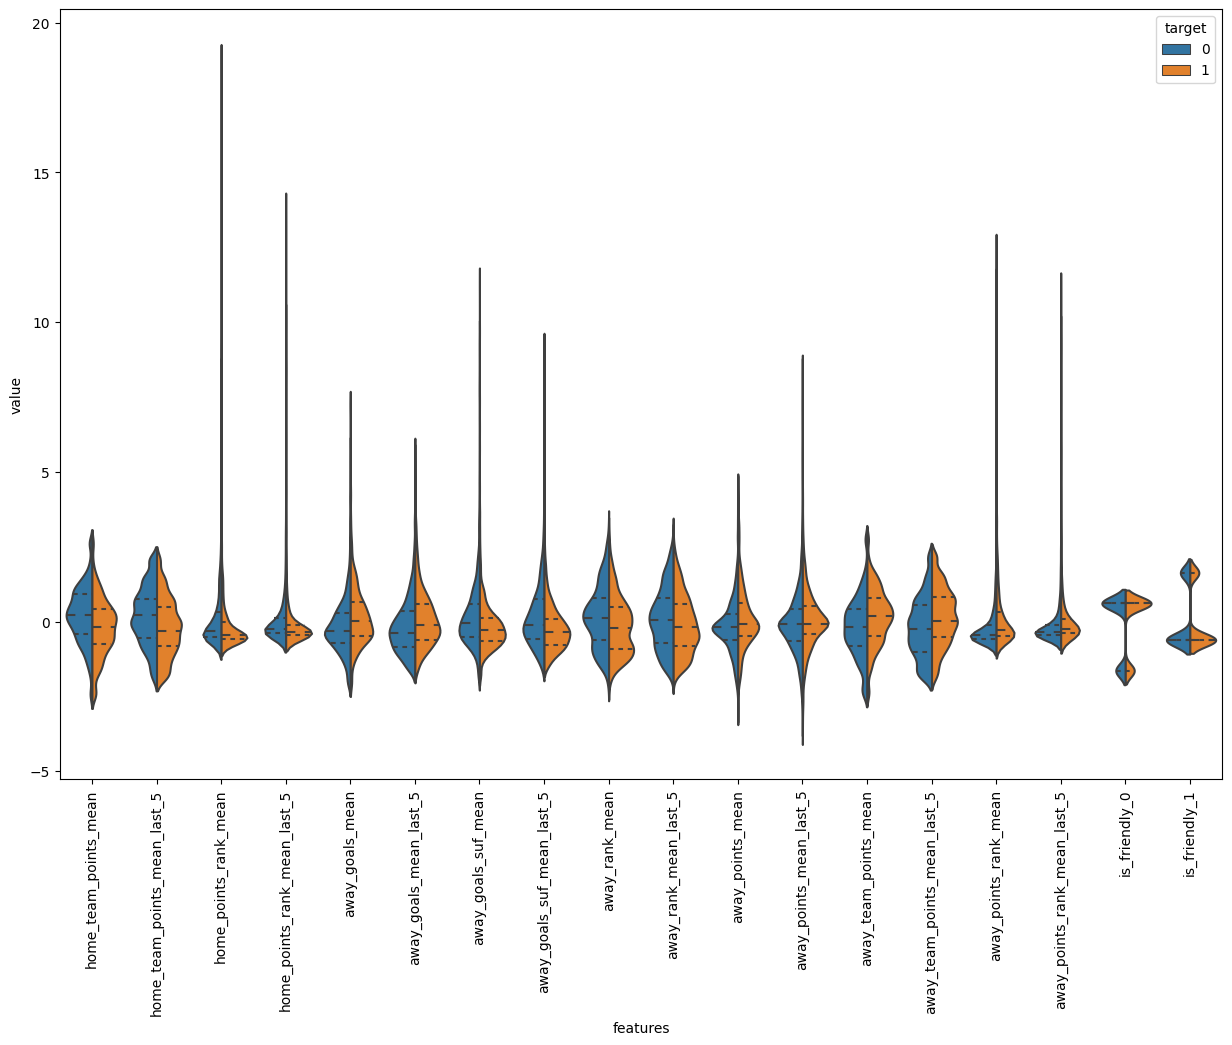

In [59]:
plt.figure(figsize=(15, 10))
sns.violinplot(x='features', y='value', hue='target', data=violin2, split=True, inner='quart')
plt.xticks(rotation=90)
plt.show()

With the plots, we find that rank difference is the only good separator of the data. But, we can create features that get the differences between home and away team and analyze if they are good separating the data.

In [60]:
diff = df.copy()

In [61]:
diff.loc[:, 'goals_diff'] = diff['home_goals_mean'] - diff['away_goals_mean']
diff.loc[:, 'goals_diff_last_5'] = diff['home_goals_mean_last_5'] - diff['away_goals_mean_last_5']
diff.loc[:, 'goals_suf_diff'] = diff['home_goals_suf_mean'] - diff['away_goals_suf_mean']
diff.loc[:, 'goals_suff_diff_last_5'] = diff['home_goals_mean_last_5'] - diff['away_goals_mean_last_5']
diff.loc[:, 'goals_made_suf_diff'] = diff["home_goals_mean"] - diff["away_goals_suf_mean"]
diff.loc[:, 'goals_made_suf_diff_last_5'] = diff["home_goals_mean_last_5"] - diff["away_goals_suf_mean_last_5"]
diff.loc[:, 'goals_suf_made_diff'] = diff["home_goals_suf_mean"] - diff["away_goals_mean"]
diff.loc[:, 'goals_suf_made_diff_last_5'] = diff["home_goals_suf_mean_last_5"] - diff["away_goals_mean_last_5"]

In [62]:
diff

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,away_goals_suf_mean,away_goals_suf_mean_last_5,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suff_diff_last_5,goals_made_suf_diff,goals_made_suf_diff_last_5,goals_suf_made_diff,goals_suf_made_diff_last_5
4,2018-08-26,Barbados,Cuba,0,0,160.0,0.0,181.0,0.0,2,-21.0,2.000000,2.0,2.000000,2.0,54.000000,54.0,0.00,0.00,1.000000,1.0,0.018519,0.018519,0.000000,0.0,1.000000,1.0,146.000000,146.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0,1,1,2.000000,2.0,1.000000,2.0,1.000000,1.0,2.000000,2.0
6,2018-08-29,Barbados,Cuba,0,2,160.0,0.0,181.0,0.0,1,-21.0,1.000000,1.0,1.000000,1.0,117.500000,117.5,0.00,0.00,1.000000,1.0,0.012022,0.012022,0.000000,0.0,0.500000,0.5,153.000000,153.0,0.00,0.00,0.500000,0.5,0.003125,0.003125,0,1,1,1.000000,1.0,0.500000,1.0,0.500000,0.5,1.000000,1.0
31,2018-09-06,Mongolia,Guam,1,1,186.0,0.0,190.0,0.0,2,-4.0,4.000000,4.0,1.000000,1.0,185.000000,185.0,0.00,0.00,3.000000,3.0,0.016216,0.016216,0.000000,0.0,2.000000,2.0,185.000000,185.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,1,0,1,4.000000,4.0,-1.000000,4.0,2.000000,2.0,1.000000,1.0
32,2018-09-06,Nepal,Bhutan,4,0,161.0,0.0,183.0,0.0,0,-22.0,1.000000,1.0,2.000000,2.0,201.000000,201.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.000000,2.0,194.000000,194.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,1,0,0,1.000000,1.0,0.000000,1.0,-1.000000,-1.0,2.000000,2.0
33,2018-09-06,Bangladesh,Pakistan,1,0,194.0,0.0,201.0,0.0,0,-7.0,1.000000,1.0,0.500000,0.5,191.500000,191.5,0.00,0.00,1.500000,1.5,0.008197,0.008197,2.000000,2.0,1.000000,1.0,161.000000,161.0,0.00,0.00,3.000000,3.0,0.018634,0.018634,1,0,0,-1.000000,-1.0,-0.500000,-1.0,0.000000,0.0,-1.500000,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,2022-12-14,Malaysia,Maldives,3,0,146.0,-2.0,154.0,-2.0,0,-8.0,1.921053,2.0,1.157895,0.8,133.052632,134.8,91.32,27.26,1.789474,1.6,0.011980,0.010218,1.153846,1.4,1.692308,1.6,149.538462,154.4,-29.75,-7.25,1.307692,1.8,0.007591,0.009363,0,1,0,0.767206,0.6,-0.534413,0.6,0.228745,0.4,0.004049,-0.6
3335,2022-12-14,Vietnam,Philippines,1,0,96.0,-1.0,133.0,-1.0,0,-37.0,1.571429,2.0,1.028571,0.4,108.028571,103.0,-1.16,0.29,1.657143,2.0,0.014049,0.022238,1.000000,0.2,1.541667,1.6,127.041667,150.4,-54.11,-12.02,1.041667,0.8,0.006806,0.004550,0,1,0,0.571429,1.8,-0.513095,1.8,0.029762,0.4,0.028571,0.2
3336,2022-12-17,Croatia,Morocco,2,1,12.0,-3.0,22.0,-1.0,0,-10.0,1.600000,1.2,1.272727,1.2,39.563636,14.2,2.64,0.00,1.636364,1.2,0.106002,0.322967,1.659574,1.0,0.510638,0.6,72.829787,12.6,141.50,0.00,2.148936,2.0,0.076014,0.409872,1,0,0,-0.059574,0.2,0.762089,0.2,1.089362,0.6,-0.386847,0.2
3337,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.344828,1.4,1.620690,1.6,125.172414,122.6,28.75,-7.52,1.379310,1.0,0.009629,0.007240,1.111111,1.4,1.740741,1.6,149.407407,161.4,-21.91,0.59,1.259259,1.8,0.007310,0.009363,0,1,0,0.233716,0.0,-0.120051,0.0,-0.395913,-0.2,0.509579,0.2


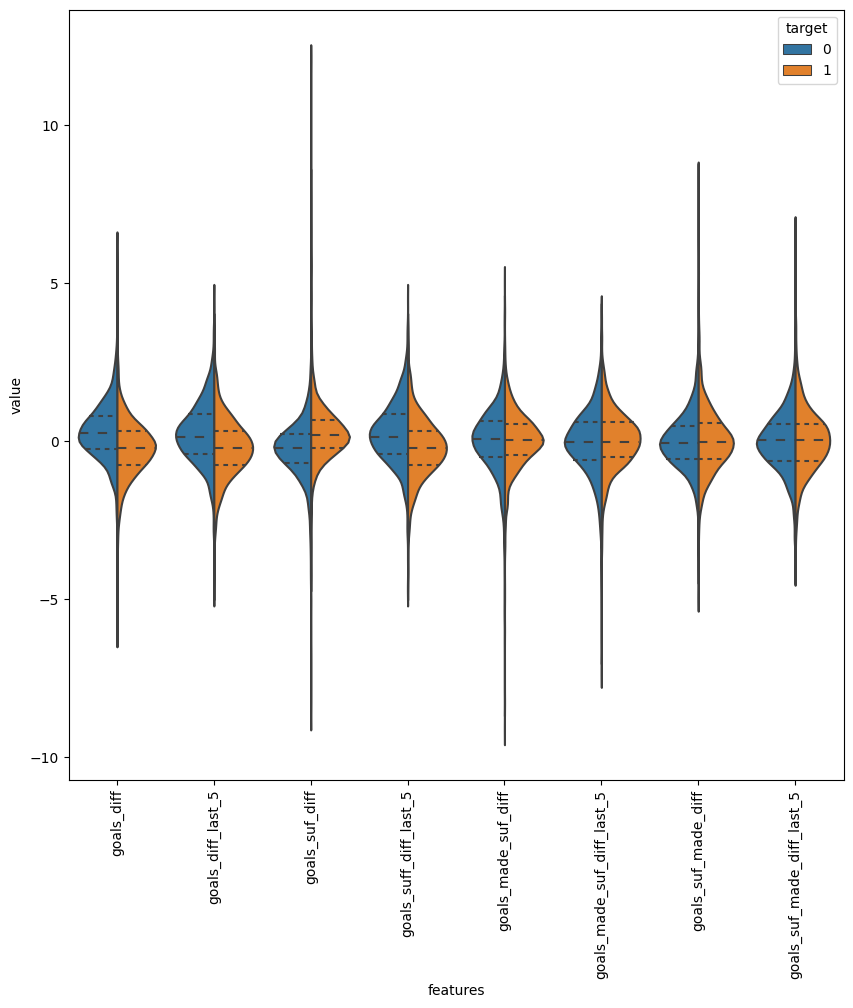

In [63]:
data_diffs = diff.iloc[:, -8:]
scaled = (data_diffs - data_diffs.mean()) / data_diffs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

With that plot we see that goal differences are good seperators and goals suffered differences too.

Now we have five features.

* rank diff
* goals_diff
* goals_diff_last_5
* goals_suf_diff
* goals_suff_diff_last_5

We can create other features, like differences of points_made by rank and differences of rank faced

In [64]:
diff.loc[:, "diff_points"] = diff["home_team_points_mean"] - diff["away_team_points_mean"]
diff.loc[:, "diff_points_last_5"] = diff["home_team_points_mean_last_5"] - diff["away_team_points_mean_last_5"]
diff.loc[:, "diff_points_rank"] = diff["home_points_rank_mean"] - diff["away_points_rank_mean"]
diff.loc[:, "diff_points_rank_last_5"] = diff["home_points_rank_mean_last_5"] - diff["away_points_rank_mean_last_5"]

In [65]:
diff.loc[:, "diff_rank_agst"] = diff["home_rank_mean"] - diff["away_rank_mean"]
diff.loc[:, "diff_rank_agst_last_5"] = diff["home_rank_mean_last_5"] - diff["away_rank_mean_last_5"]

In [66]:
diff

,date,home_team,away_team,home_score,away_score,rank_home,rank_change_home,rank_away,rank_change_away,result,rank_diff,home_goals_mean,home_goals_mean_last_5,home_goals_suf_mean,home_goals_suf_mean_last_5,home_rank_mean,home_rank_mean_last_5,home_points_mean,home_points_mean_last_5,home_team_points_mean,home_team_points_mean_last_5,home_points_rank_mean,home_points_rank_mean_last_5,away_goals_mean,away_goals_mean_last_5,...,away_rank_mean,away_rank_mean_last_5,away_points_mean,away_points_mean_last_5,away_team_points_mean,away_team_points_mean_last_5,away_points_rank_mean,away_points_rank_mean_last_5,is_friendly_0,is_friendly_1,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suff_diff_last_5,goals_made_suf_diff,goals_made_suf_diff_last_5,goals_suf_made_diff,goals_suf_made_diff_last_5,diff_points,diff_points_last_5,diff_points_rank,diff_points_rank_last_5,diff_rank_agst,diff_rank_agst_last_5
4,2018-08-26,Barbados,Cuba,0,0,160.0,0.0,181.0,0.0,2,-21.0,2.000000,2.0,2.000000,2.0,54.000000,54.0,0.00,0.00,1.000000,1.0,0.018519,0.018519,0.000000,0.0,...,146.000000,146.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0,1,1,2.000000,2.0,1.000000,2.0,1.000000,1.0,2.000000,2.0,1.000000,1.0,0.018519,0.018519,-92.000000,-92.0
6,2018-08-29,Barbados,Cuba,0,2,160.0,0.0,181.0,0.0,1,-21.0,1.000000,1.0,1.000000,1.0,117.500000,117.5,0.00,0.00,1.000000,1.0,0.012022,0.012022,0.000000,0.0,...,153.000000,153.0,0.00,0.00,0.500000,0.5,0.003125,0.003125,0,1,1,1.000000,1.0,0.500000,1.0,0.500000,0.5,1.000000,1.0,0.500000,0.5,0.008897,0.008897,-35.500000,-35.5
31,2018-09-06,Mongolia,Guam,1,1,186.0,0.0,190.0,0.0,2,-4.0,4.000000,4.0,1.000000,1.0,185.000000,185.0,0.00,0.00,3.000000,3.0,0.016216,0.016216,0.000000,0.0,...,185.000000,185.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,1,0,1,4.000000,4.0,-1.000000,4.0,2.000000,2.0,1.000000,1.0,3.000000,3.0,0.016216,0.016216,0.000000,0.0
32,2018-09-06,Nepal,Bhutan,4,0,161.0,0.0,183.0,0.0,0,-22.0,1.000000,1.0,2.000000,2.0,201.000000,201.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,194.000000,194.0,0.00,0.00,0.000000,0.0,0.000000,0.000000,1,0,0,1.000000,1.0,0.000000,1.0,-1.000000,-1.0,2.000000,2.0,0.000000,0.0,0.000000,0.000000,7.000000,7.0
33,2018-09-06,Bangladesh,Pakistan,1,0,194.0,0.0,201.0,0.0,0,-7.0,1.000000,1.0,0.500000,0.5,191.500000,191.5,0.00,0.00,1.500000,1.5,0.008197,0.008197,2.000000,2.0,...,161.000000,161.0,0.00,0.00,3.000000,3.0,0.018634,0.018634,1,0,0,-1.000000,-1.0,-0.500000,-1.0,0.000000,0.0,-1.500000,-1.5,-1.500000,-1.5,-0.010437,-0.010437,30.500000,30.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,2022-12-14,Malaysia,Maldives,3,0,146.0,-2.0,154.0,-2.0,0,-8.0,1.921053,2.0,1.157895,0.8,133.052632,134.8,91.32,27.26,1.789474,1.6,0.011980,0.010218,1.153846,1.4,...,149.538462,154.4,-29.75,-7.25,1.307692,1.8,0.007591,0.009363,0,1,0,0.767206,0.6,-0.534413,0.6,0.228745,0.4,0.004049,-0.6,0.481781,-0.2,0.004389,0.000855,-16.485830,-19.6
3335,2022-12-14,Vietnam,Philippines,1,0,96.0,-1.0,133.0,-1.0,0,-37.0,1.571429,2.0,1.028571,0.4,108.028571,103.0,-1.16,0.29,1.657143,2.0,0.014049,0.022238,1.000000,0.2,...,127.041667,150.4,-54.11,-12.02,1.041667,0.8,0.006806,0.004550,0,1,0,0.571429,1.8,-0.513095,1.8,0.029762,0.4,0.028571,0.2,0.615476,1.2,0.007243,0.017688,-19.013095,-47.4
3336,2022-12-17,Croatia,Morocco,2,1,12.0,-3.0,22.0,-1.0,0,-10.0,1.600000,1.2,1.272727,1.2,39.563636,14.2,2.64,0.00,1.636364,1.2,0.106002,0.322967,1.659574,1.0,...,72.829787,12.6,141.50,0.00,2.148936,2.0,0.076014,0.409872,1,0,0,-0.059574,0.2,0.762089,0.2,1.089362,0.6,-0.386847,0.2,-0.512573,-0.8,0.029987,-0.086905,-33.266151,1.6
3337,2022-12-17,Singapore,Maldives,3,1,160.0,1.0,154.0,-2.0,0,6.0,1.344828,1.4,1.620690,1.6,125.172414,122.6,28.75,-7.52,1.379310,1.0,0.009629,0.007240,1.111111,1.4,...,149.407407,161.4,-21.91,0.59,1.259259,1.8,0.007310,0.009363,0,1,0,0.23371

In [67]:
diff.loc[:, "goals_per_ranking_diff"] = (diff["home_goals_mean"] / diff["home_rank_mean"]) - (diff["away_goals_mean"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_suf_diff"] = (diff["home_goals_suf_mean"] / diff["home_rank_mean"]) - (diff["away_goals_suf_mean"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_diff_last_5"] = (diff["home_goals_mean_last_5"] / diff["home_rank_mean"]) - (diff["away_goals_mean_last_5"] / diff["away_rank_mean"])
diff.loc[:, "goals_per_ranking_suf_diff_last_5"] = (diff["home_goals_suf_mean_last_5"] / diff["home_rank_mean"]) - (diff["away_goals_suf_mean_last_5"] / diff["away_rank_mean"])

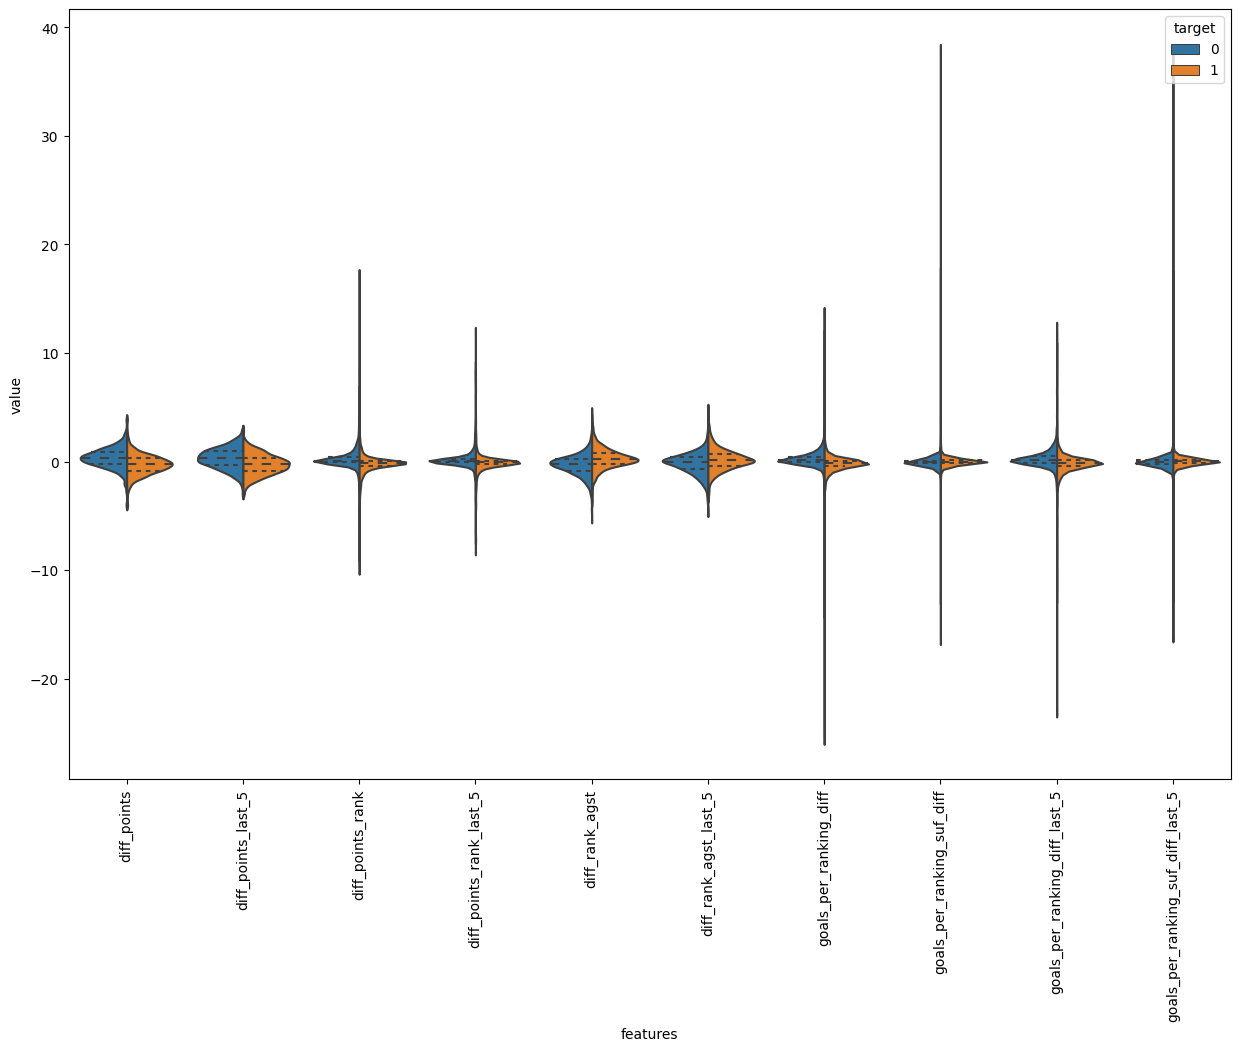

In [68]:
data_diffs = diff.iloc[:, -10:]
scaled = (data_diffs - data_diffs.mean()) / data_diffs.std()
scaled["target"] = data2["target"]
violin = pd.melt(scaled,id_vars="target", var_name="features", value_name="value")

plt.figure(figsize=(15,10))
sns.violinplot(x="features", y="value", hue="target", data=violin,split=True, inner="quart")
plt.xticks(rotation=90)
plt.show()

Due to the low values, the violin plot was not a good choice to analyze if features are really separating the data in this case. We will see then the boxplot:

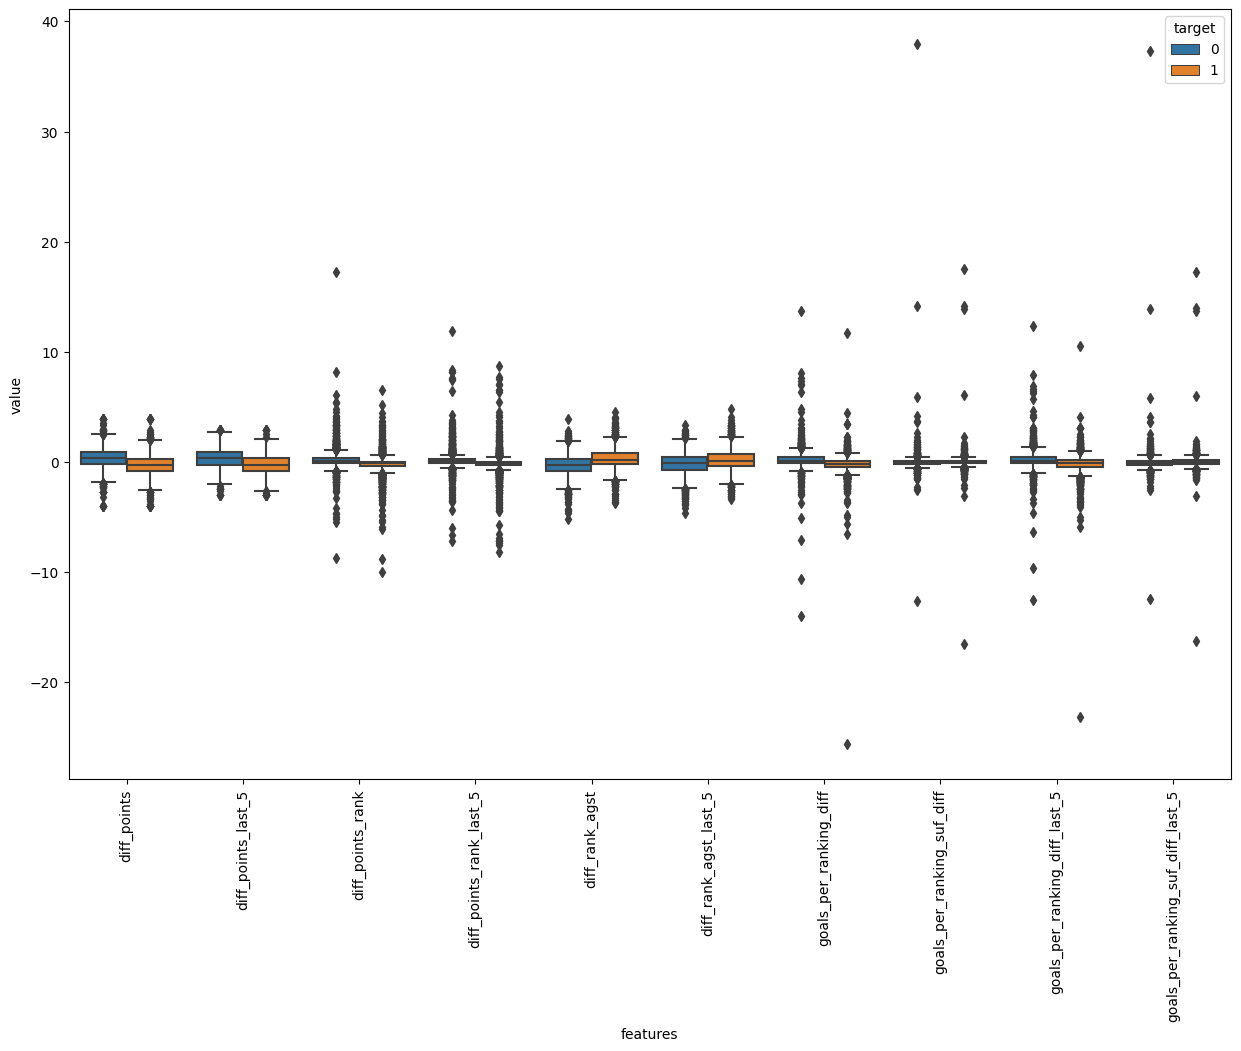

In [69]:
plt.figure(figsize=(15,10))
sns.boxplot(x="features", y="value", hue="target", data=violin)
plt.xticks(rotation=90)
plt.show()

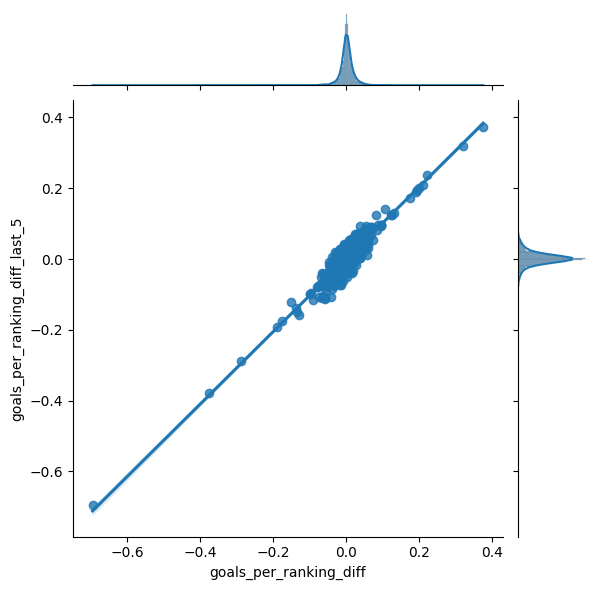

In [70]:
sns.jointplot(data=data_diffs, x='goals_per_ranking_diff', y='goals_per_ranking_diff_last_5', kind='reg')
plt.show()

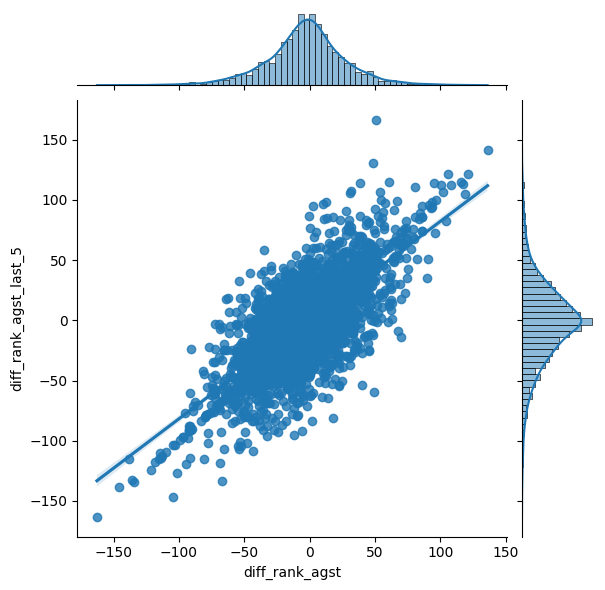

In [71]:
sns.jointplot(data = data_diffs, x = 'diff_rank_agst', y = 'diff_rank_agst_last_5', kind="reg")
plt.show()

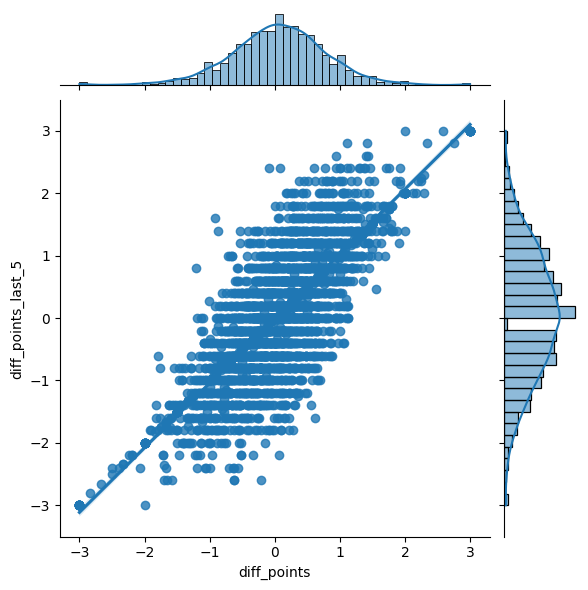

In [72]:
sns.jointplot(data = data_diffs, x = 'diff_points', y = 'diff_points_last_5', kind="reg")
plt.show()

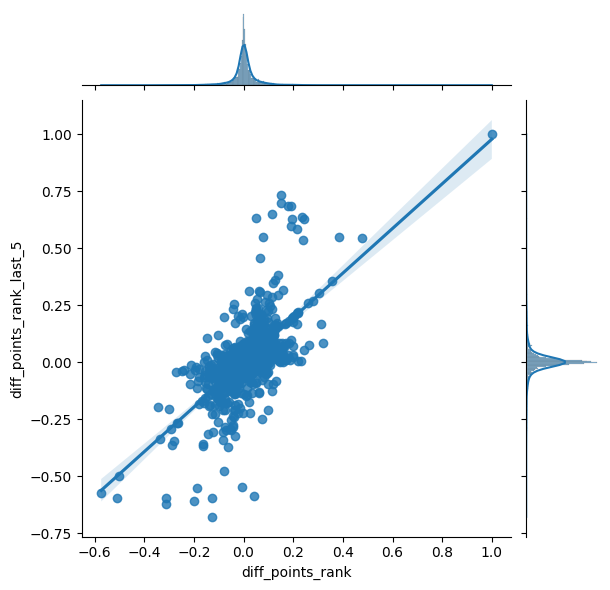

In [73]:
sns.jointplot(data = data_diffs, x = 'diff_points_rank', y = 'diff_points_rank_last_5', kind="reg")
plt.show()

Based on that, final features are:

* rank_diff
* goals_diff
* goals_diff_last_5
* goals_suf_diff
* goals_suf_diff_last_5
* diff_rank_agst
* diff_rank_agst_last_5
* goals_per_ranking_diff
* diff_points_rank
* diff_points_rank_last_5
* is_friendly

In [74]:
def create_data(df):
        columns = ["date", "home_team", "away_team", "home_score", "away_score", "target", "rank_diff",
                   "home_goals_mean", "home_rank_mean", "away_goals_mean",
                   "away_rank_mean", "home_rank_mean_last_5", "away_rank_mean_last_5",
                   "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_last_5",
                   "away_goals_mean_last_5", "home_goals_suf_mean_last_5", "away_goals_suf_mean_last_5",
                   "home_points_rank_mean", "home_points_rank_mean_last_5",
                   "away_points_rank_mean", "away_points_rank_mean_last_5","is_friendly_0", "is_friendly_1"]

        base = df.loc[:, columns]
        base = base[base['date'] > '2018-01-01']
        base.loc[:, 'goals_diff'] = base["home_goals_mean"] - base["away_goals_mean"]
        base.loc[:, "goals_diff_last_5"] = base["home_goals_mean_last_5"] - base["away_goals_mean_last_5"]
        base.loc[:, "goals_suf_diff"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
        base.loc[:, "goals_suf_diff_last_5"] = base["home_goals_suf_mean_last_5"] - base["away_goals_suf_mean_last_5"]
        base.loc[:, "goals_per_ranking_diff"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])
        base.loc[:, "diff_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
        base.loc[:, "diff_rank_agst_last_5"] = base["home_rank_mean_last_5"] - base["away_rank_mean_last_5"]
        base.loc[:, "diff_points_rank"] = base["home_points_rank_mean"] - base["away_points_rank_mean"]
        base.loc[:, "diff_points_rank_last_5"] = base["home_points_rank_mean_last_5"] - base["away_points_rank_mean_last_5"]
        
        data = base[['home_team', 'away_team', 'rank_diff', 'target', 'goals_diff', 'goals_diff_last_5', 'goals_suf_diff', 'goals_suf_diff_last_5',
                    'goals_per_ranking_diff', 'diff_rank_agst', 'diff_rank_agst_last_5', 'diff_points_rank',
                    'diff_points_rank_last_5', 'is_friendly_0', 'is_friendly_1']]
        return data.reset_index(drop=True)
        

In [75]:
data = create_data(df)

In [76]:
data.head()

,home_team,away_team,rank_diff,target,goals_diff,goals_diff_last_5,goals_suf_diff,goals_suf_diff_last_5,goals_per_ranking_diff,diff_rank_agst,diff_rank_agst_last_5,diff_points_rank,diff_points_rank_last_5,is_friendly_0,is_friendly_1
0,Barbados,Cuba,-21.0,1,2.0,2.0,1.0,1.0,0.037037,-92.0,-92.0,0.018519,0.018519,0,1
1,Barbados,Cuba,-21.0,1,1.0,1.0,0.5,0.5,0.008511,-35.5,-35.5,0.008897,0.008897,0,1
2,Mongolia,Guam,-4.0,1,4.0,4.0,-1.0,-1.0,0.021622,0.0,0.0,0.016216,0.016216,1,0
3,Nepal,Bhutan,-22.0,0,1.0,1.0,0.0,0.0,0.004975,7.0,7.0,0.000000,0.000000,1,0
4,Bangladesh,Pakistan,-7.0,0,-1.0,-1.0,-0.5,-0.5,-0.007200,30.5,30.5,-0.010437,-0.010437,1,0


## The model

Now, that we have the data ready, we can start modeling.

Now you are ready to do stratified sampling based on the income category. For this we can use Scikit-Learn’s StratifiedShuffleSplit class:

In [77]:
data['goals_diff'].std()

0.8304953731365845

<AxesSubplot: >

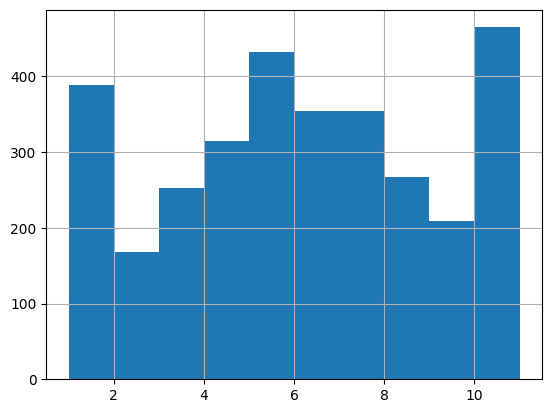

In [78]:
data['strata'] = pd.cut(data['goals_diff'], 
                        bins=[-np.inf, -0.8, -0.6, -0.4, -0.2, 0.,0.2, 0.4, 0.6, 0.8, 1, np.inf],
                        labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
data['strata'].hist()

In [79]:
data.isna().sum()

home_team                  0
away_team                  0
rank_diff                  0
target                     0
goals_diff                 0
goals_diff_last_5          0
goals_suf_diff             0
goals_suf_diff_last_5      0
goals_per_ranking_diff     0
diff_rank_agst             0
diff_rank_agst_last_5      0
diff_points_rank           0
diff_points_rank_last_5    0
is_friendly_0              0
is_friendly_1              0
strata                     0
dtype: int64

In [80]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['strata']):
    strata_train_set = data.loc[train_index]
    strata_test_set = data.loc[test_index]

In [81]:
strata_train_set = strata_train_set.drop('strata', axis=1)
strata_test_set = strata_test_set.drop('strata', axis=1)

In [82]:
x_test = strata_test_set.drop(['home_team', 'away_team', 'target'], axis=1)
y_test = np.ravel(strata_test_set[['target']].to_numpy())

In [83]:
x_train = strata_train_set.drop(['home_team', 'away_team', 'target'], axis=1)
y_train = np.ravel(strata_train_set[['target']].to_numpy())

In [84]:
cols = x_train.columns

pipeline = ColumnTransformer([
    ('num', StandardScaler(), cols)
])

In [85]:
x_train = pipeline.fit_transform(x_train)

In [86]:
y_train.shape

(2564,)

Select a model to check a bit how it is performin

In [87]:
from sklearn.ensemble import RandomForestClassifier,\
                             GradientBoostingClassifier
import lightgbm as lgb

In [88]:
light = lgb.LGBMClassifier(random_state=42)
params = {'learning_rate': [0.01], 'n_estimators': [8, 24],
                   'num_leaves': [6, 8, 12, 16], 'boosting_type': ['gbdt'], 
                   'objective': ['binary'], 'seed': [500],
                   'colsample_bytree': [0.65, 0.75, 0.8], 
                   'subsample': [0.7, 0.75], 'reg_alpha': [1, 2, 6],
                   'reg_lambda': [1, 2, 6]}

light_cv = GridSearchCV(light, params, n_jobs=-1, cv=3, verbose=False)
light_cv.fit(x_train, y_train)

[LightGBM] [Warning] seed is set=500, random_state=42 will be ignored. Current value: seed=500


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01], 'n_estimators': [8, 24],
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
                         'reg_alpha': [1, 2, 6], 'reg_lambda': [1, 2, 6],
                         'seed': [500], 'subsample': [0.7, 0.75]},
             verbose=False)

In [89]:
light = light_cv.best_estimator_
light

LGBMClassifier(colsample_bytree=0.65, learning_rate=0.01, n_estimators=24,
               num_leaves=12, objective='binary', random_state=42, reg_alpha=2,
               reg_lambda=1, seed=500, subsample=0.7)

In [90]:
gb = GradientBoostingClassifier(random_state=42)
params = {"learning_rate": [0.01, 0.1, 0.5],
          "min_samples_split": [5, 10],
          "min_samples_leaf": [3, 5],
          "max_depth":[3,5,10],
          "max_features":["sqrt"],
          "n_estimators":[100, 200]
         }

gb_cv = GridSearchCV(gb, params, n_jobs=-1, cv=3, verbose=False)
gb_cv.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [91]:
gb = gb_cv.best_estimator_
gb

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=42)

In [92]:
rf = RandomForestClassifier(random_state=42)
params_rf = {"max_depth": [20],
             "min_samples_split": [10],
             "max_leaf_nodes": [175],
             "min_samples_leaf": [5],
             "n_estimators": [250],
             "max_features": ["sqrt"],
            }
rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)
rf_cv.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [93]:
rf = rf_cv.best_estimator_
rf

RandomForestClassifier(max_depth=20, max_leaf_nodes=175, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=250, random_state=42)

In [94]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [95]:
def analyze(model, x_train, x_test):
    x_test = pipeline.transform(x_test)
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1]) #test AUC
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(x_train)[:,1]) #train AUC
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(x_test)[:,1])
    auc_train = roc_auc_score(y_train, model.predict_proba(x_train)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()
    
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(x_test))
    sns.heatmap(cm, annot=True, fmt="d")

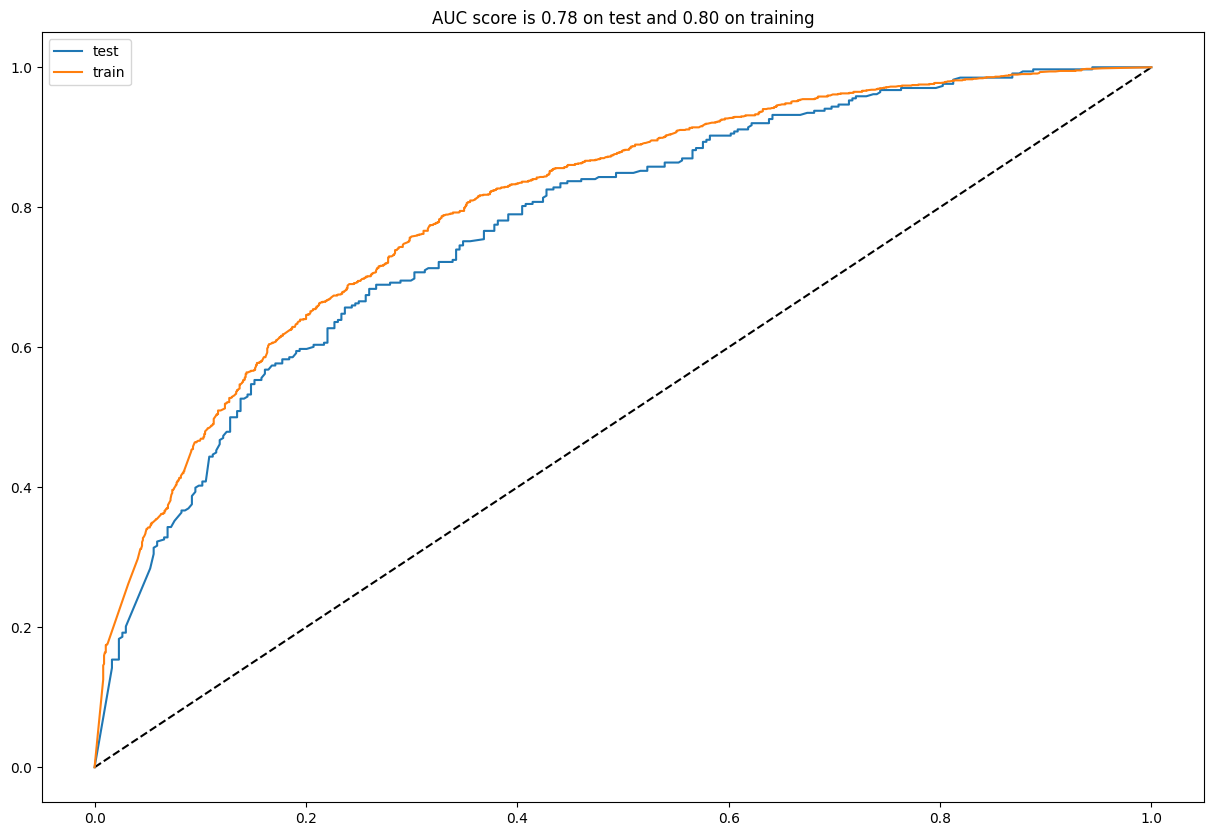

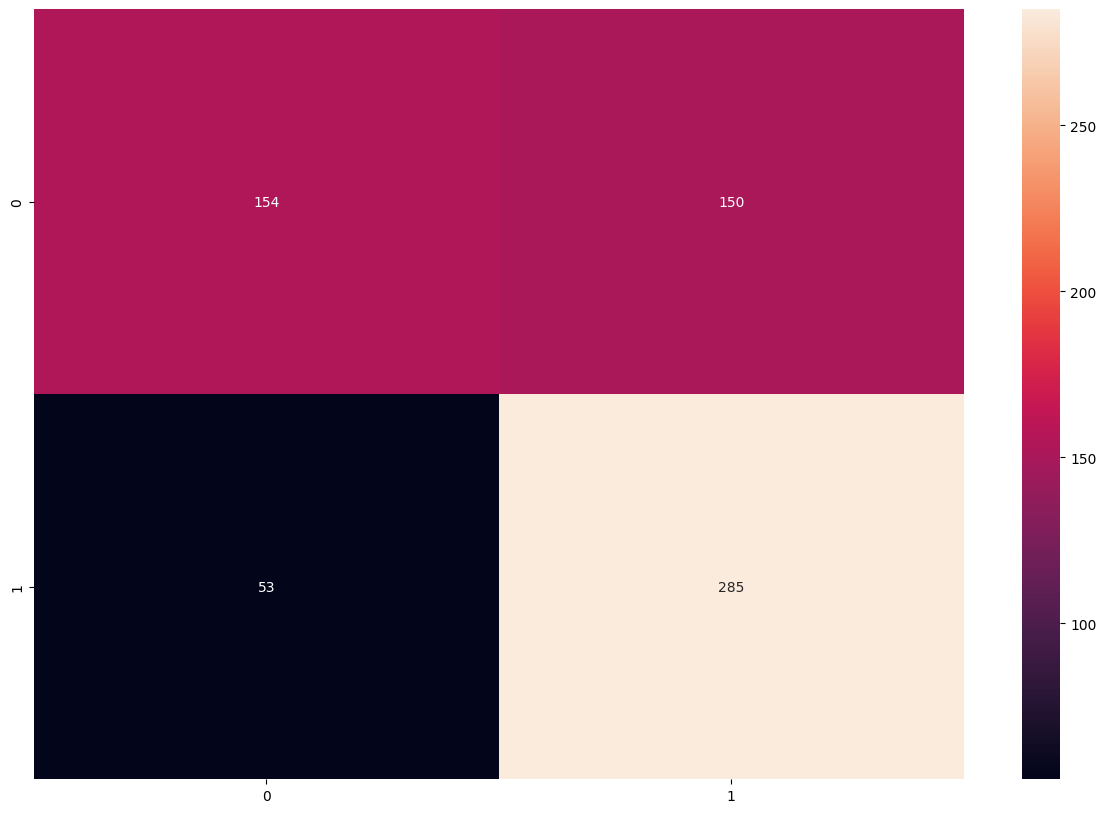

In [96]:
analyze(light, x_train, x_test)

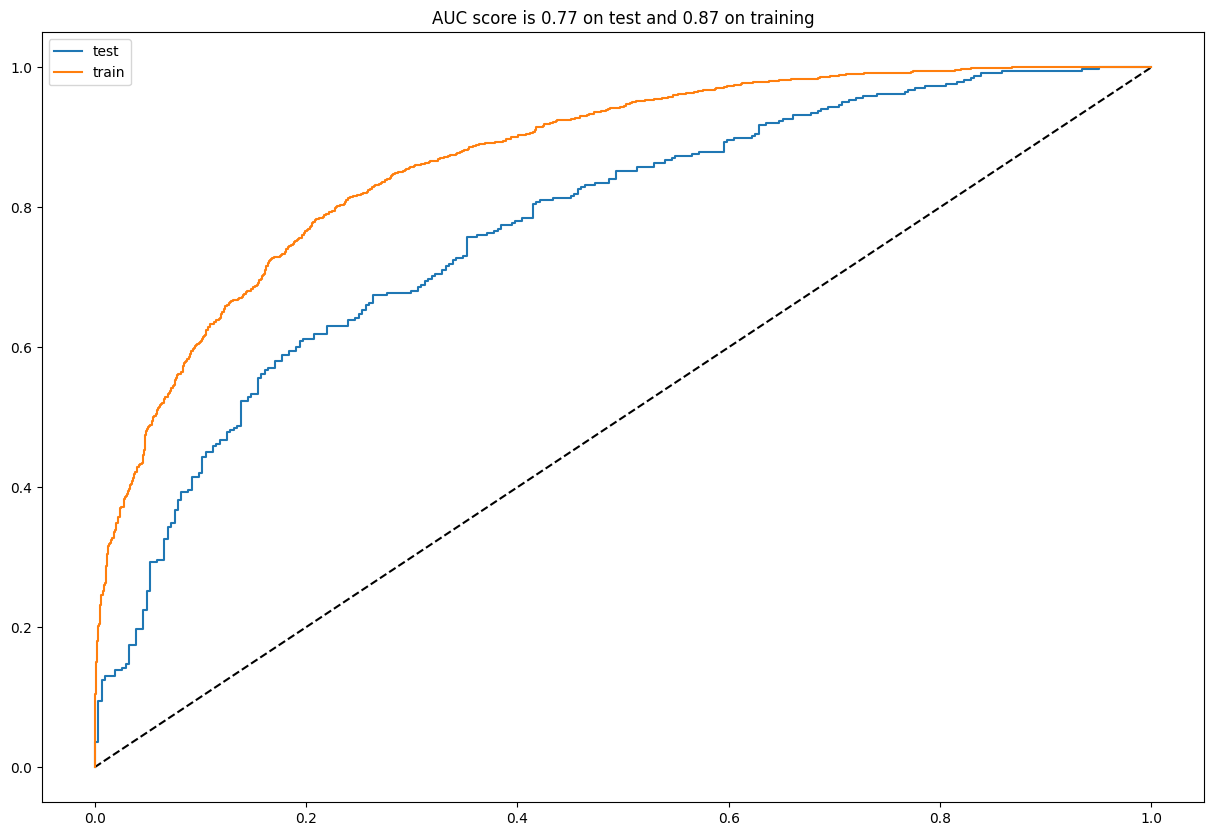

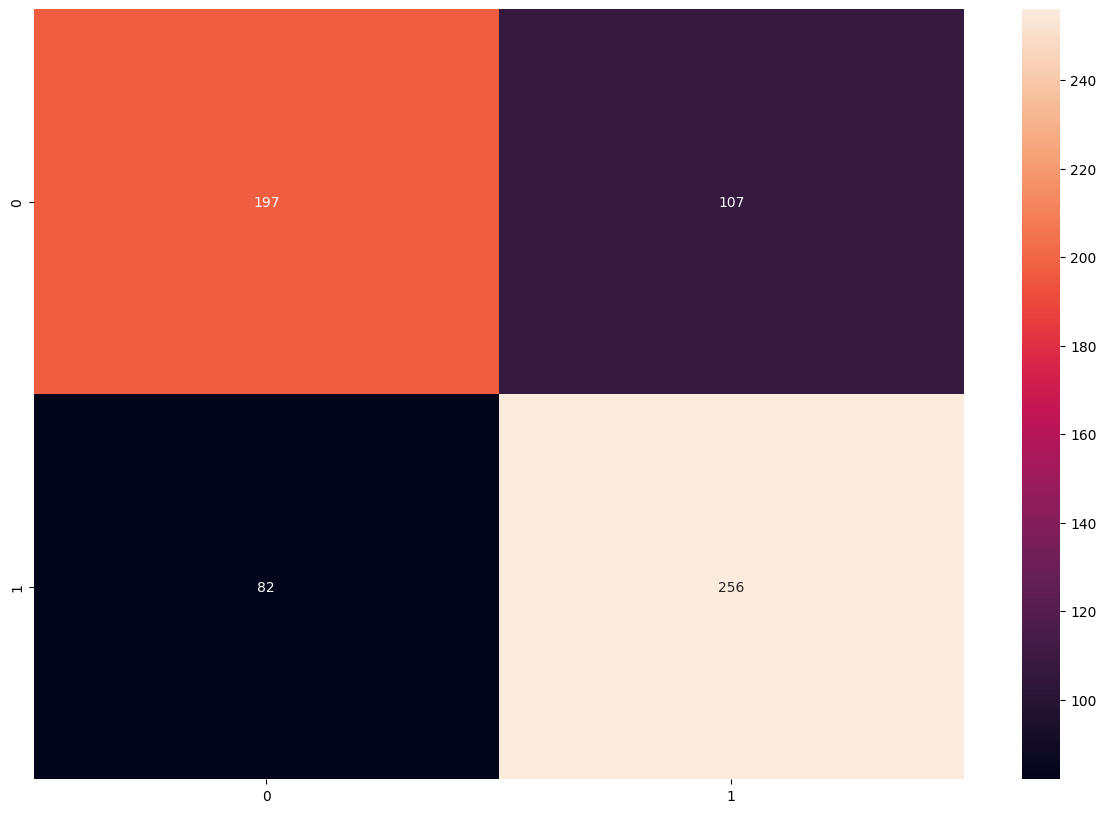

In [97]:
analyze(gb, x_train, x_test)

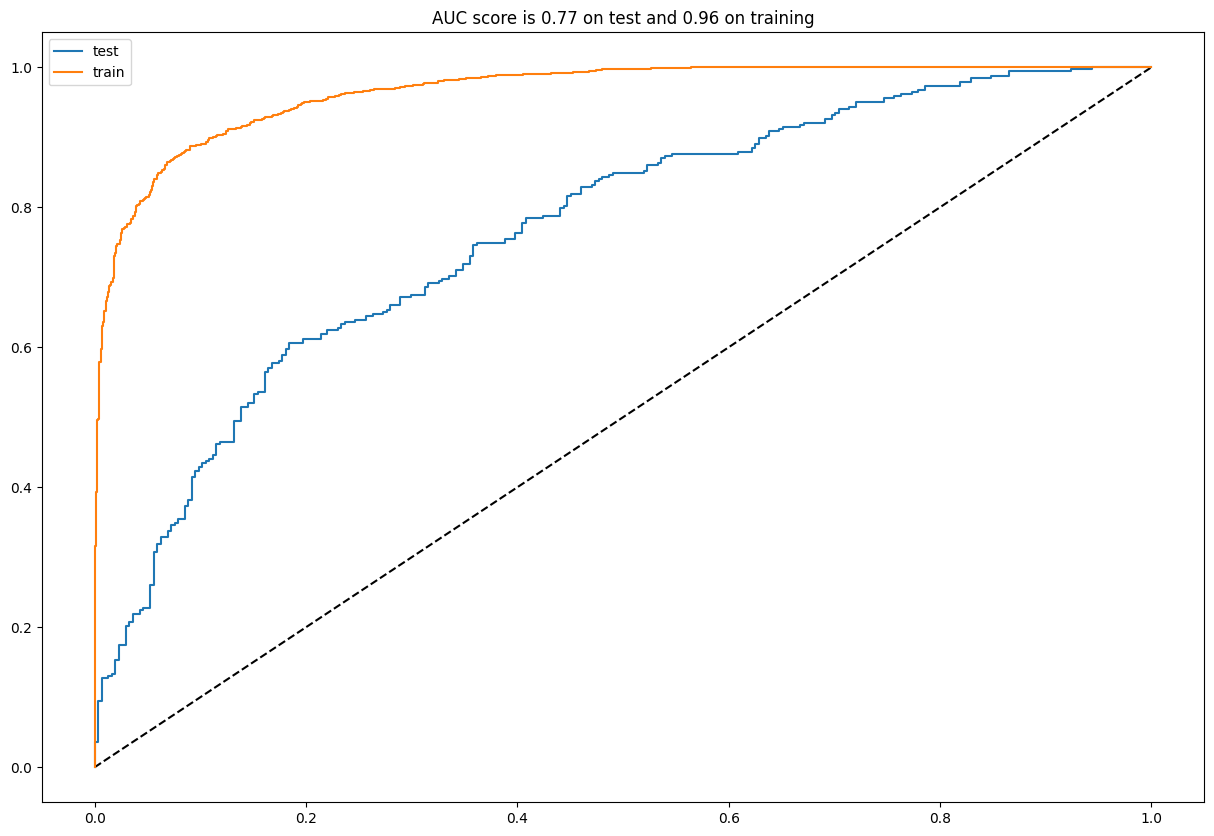

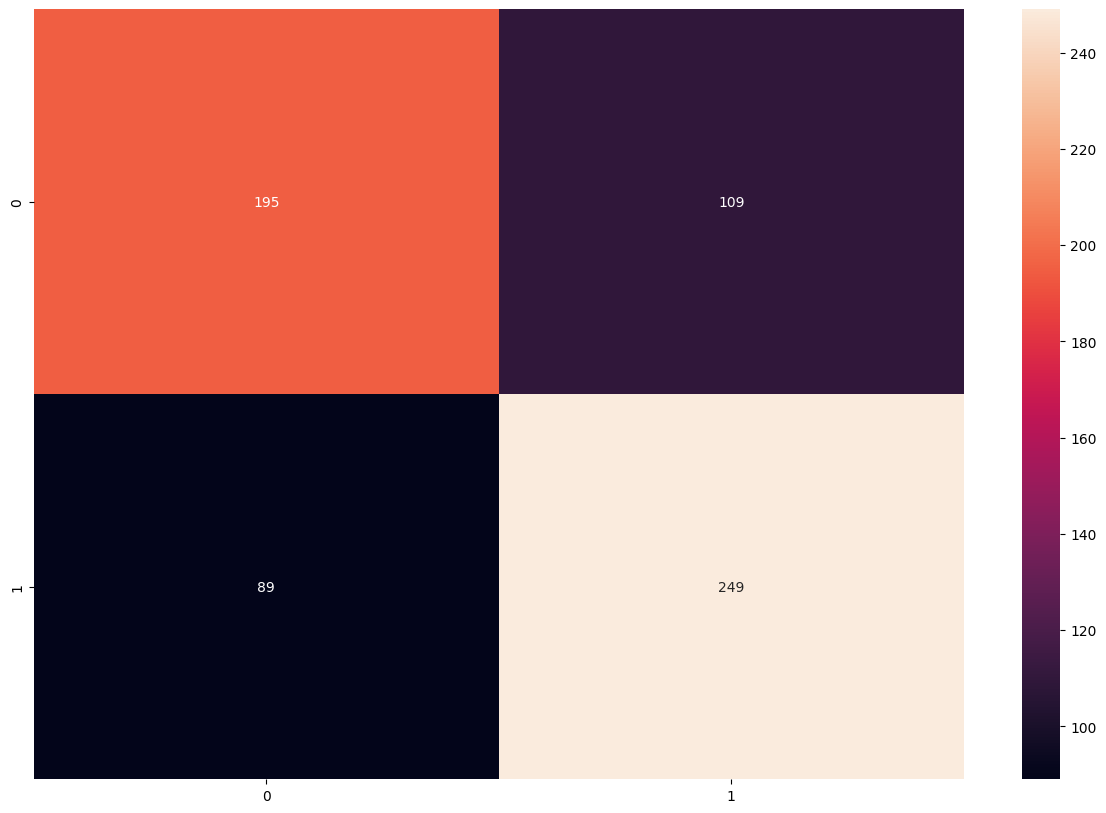

In [98]:
analyze(rf, x_train, x_test)

## WC Simulation

First thing to create fifa world cup games

In [99]:
dfs = pd.read_html(r"https://en.wikipedia.org/wiki/2022_FIFA_World_Cup#Teams")

In [129]:
for i in range(len(dfs)):
    df = dfs[i]
    cols = list(df.columns.values)
    
    if isinstance(cols[0], Iterable):
        if any('Tie-breaking criteria' in c for c in cols):
            start_pos=i+1
        if any('Match 46' in c for c in cols):
            end_pos=i+1

In [130]:
end_pos = 0

In [131]:
matches = []
groups = ["A", "B", "C", "D", "E", "F", "G", "H"]
group_count = 0 

table = {}
#TABLE -> TEAM, POINTS, WIN PROBS (CRITERIO DE DESEMPATE)
table[groups[group_count]] = [[a.split(" ")[0], 0, []] for a in list(dfs[start_pos].iloc[:, 1].values)]

for i in range(start_pos+1, end_pos, 1):
    if len(dfs[i].columns) == 3:
        team_1 = dfs[i].columns.values[0]
        team_2 = dfs[i].columns.values[-1]
        
        matches.append((groups[group_count], team_1, team_2))
    else:
        group_count+=1
        table[groups[group_count]] = [[a, 0, []] for a in list(dfs[i].iloc[:, 1].values)]

In [132]:
table

{'A': [['Netherlands', 0, []],
  ['Senegal', 0, []],
  ['Ecuador', 0, []],
  ['Qatar', 0, []]]}